In [124]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

from functions import *

sns.set_style("white")
plt.rcParams['figure.dpi'] = 75

In [125]:
wide_matrix = get_linear_regression_matrix()

In [126]:
wide_matrix.head()

,sequence_name,STREME-1,STREME-2,STREME-3,STREME-4,STREME-5,STREME-6,STREME-7,STREME-9,STREME-10,...,STREME-37,STREME-38,STREME-41,STREME-42,STREME-43,STREME-44,STREME-45,STREME-46,STREME-47,signal_value
0,X:5794883-5797178,0,0,0,0,0,0,0,1,1,...,3,0,0,0,1,30,2,0,0,48
1,3L:17576814-17578210,0,0,0,16,1,2,0,2,1,...,1,0,0,1,1,6,1,2,0,654
2,2R:15744192-15745896,1,0,2,0,0,0,0,0,1,...,1,2,0,0,1,10,0,0,0,443
3,2R:14048903-14050073,2,0,2,0,0,0,0,0,0,...,2,0,0,0,8,10,0,0,0,1519
4,2R:24969269-24969879,0,2,0,0,0,1,0,0,0,...,0,0,0,0,1,4,1,0,0,88


Text(0.5, 1.0, 'Signal value from narrowpeak')

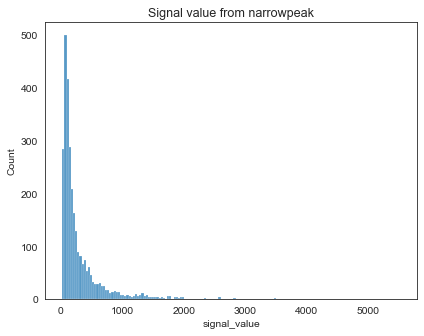

In [127]:
sns.histplot(data=wide_matrix, x='signal_value')
plt.title('Signal value from narrowpeak')

This is fairly skewed and spans quite a large range. I will take the log transform

In [128]:
wide_matrix.signal_value = np.log(wide_matrix.signal_value)

Text(0.5, 1.0, 'Log transformed signal value')

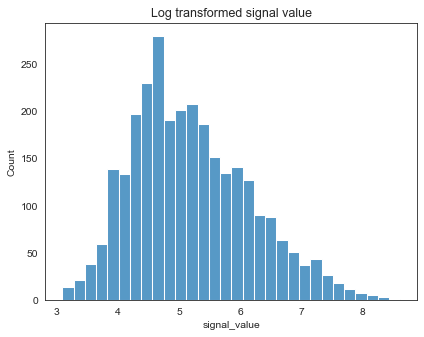

In [129]:
sns.histplot(data=wide_matrix, x='signal_value')
plt.title('Log transformed signal value')

That looks much better. We will use this.

Now to create our model and see how well it performs (I will qualify it later)

In [130]:
features = wide_matrix.iloc[:, 1:-1]
response = wide_matrix.iloc[:, -1:]

In [131]:
features.head()

,STREME-1,STREME-2,STREME-3,STREME-4,STREME-5,STREME-6,STREME-7,STREME-9,STREME-10,STREME-11,...,STREME-36,STREME-37,STREME-38,STREME-41,STREME-42,STREME-43,STREME-44,STREME-45,STREME-46,STREME-47
0,0,0,0,0,0,0,0,1,1,0,...,0,3,0,0,0,1,30,2,0,0
1,0,0,0,16,1,2,0,2,1,0,...,0,1,0,0,1,1,6,1,2,0
2,1,0,2,0,0,0,0,0,1,0,...,0,1,2,0,0,1,10,0,0,0
3,2,0,2,0,0,0,0,0,0,0,...,7,2,0,0,0,8,10,0,0,0
4,0,2,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,4,1,0,0


In [132]:
response.head()

,signal_value
0,3.871201
1,6.483107
2,6.093570
3,7.325808
4,4.477337


In [133]:
df_to_statsmodels = pd.DataFrame()


# Renaming the training data features without the dash so statsmodels can stop complaining
rename_X = {}
for column in features.columns:
    rename_X[column] = "".join(column.split('-'))

X_train = features.rename(columns=rename_X)

df_to_statsmodels = pd.concat([df_to_statsmodels, X_train], axis=1)
print(df_to_statsmodels.shape)
df_to_statsmodels['signal_strength'] = response
df_to_statsmodels.head()

(2902, 36)


,STREME1,STREME2,STREME3,STREME4,STREME5,STREME6,STREME7,STREME9,STREME10,STREME11,...,STREME37,STREME38,STREME41,STREME42,STREME43,STREME44,STREME45,STREME46,STREME47,signal_strength
0,0,0,0,0,0,0,0,1,1,0,...,3,0,0,0,1,30,2,0,0,3.871201
1,0,0,0,16,1,2,0,2,1,0,...,1,0,0,1,1,6,1,2,0,6.483107
2,1,0,2,0,0,0,0,0,1,0,...,1,2,0,0,1,10,0,0,0,6.093570
3,2,0,2,0,0,0,0,0,0,0,...,2,0,0,0,8,10,0,0,0,7.325808
4,0,2,0,0,0,1,0,0,0,0,...,0,0,0,0,1,4,1,0,0,4.477337


In [134]:
model_string = "signal_strength ~ "
for col in X_train.columns:
    if col != "signal_strength":
        model_string += f"{col} + "

model_string = model_string[:-2]
# model_string = f'{model_string} - 1'

y, X = dmatrices(model_string, data=df_to_statsmodels, return_type="dataframe")
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2902 entries, 0 to 2901
Data columns (total 37 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Intercept  2902 non-null   float64
 1   STREME1    2902 non-null   float64
 2   STREME2    2902 non-null   float64
 3   STREME3    2902 non-null   float64
 4   STREME4    2902 non-null   float64
 5   STREME5    2902 non-null   float64
 6   STREME6    2902 non-null   float64
 7   STREME7    2902 non-null   float64
 8   STREME9    2902 non-null   float64
 9   STREME10   2902 non-null   float64
 10  STREME11   2902 non-null   float64
 11  STREME12   2902 non-null   float64
 12  STREME13   2902 non-null   float64
 13  STREME14   2902 non-null   float64
 14  STREME15   2902 non-null   float64
 15  STREME16   2902 non-null   float64
 16  STREME17   2902 non-null   float64
 17  STREME18   2902 non-null   float64
 18  STREME19   2902 non-null   float64
 19  STREME20   2902 non-null   float64
 20  STREME21

In [135]:
linear_model = sm.OLS(y, X)
results = linear_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        signal_strength   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     16.60
Date:                Wed, 08 Feb 2023   Prob (F-statistic):           2.29e-92
Time:                        13:23:29   Log-Likelihood:                -3740.2
No. Observations:                2902   AIC:                             7554.
Df Residuals:                    2865   BIC:                             7775.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6089      0.031    151.020      0.000       4.549       4.669
STREME1        0.1166      0.025      4.689      0.000       0.068       0.165
STREME2        0.0123      0.024      0.503      0.615      -0.036       0.060
STREME3        0.1062      0.017      6.106      0.000       0.072       0.140
STREME4        0.0112      0.008      1.481      0.139      -0.004       0.026
STREME5        0.0369      0.019      1.917      0.055      -0.001       0.075
STREME6       -0.0294      0.020     -1.450      0.147      -0.069       0.010
STREME7        0.0469      0.032      1.461      0.144      -0.016       0.110
STREME9        0.0223      0.014      1.561      0.119      -0.006       0.050
STREME10       0.0965      0.030      3.257      0.001       0.038       0.155
STREME11       0.1385      0.044      3.182      0.001       0.053       0.224
STREME12       0.0028      0.006      0.436      0.663      -0.010       0.015
STREME13       0.0027      0.031      0.088      0.930      -0.058       0.063
STREME14       0.1252      0.030      4.186      0.000       0.067       0.184
STREME15      -0.0101      0.013     -0.773      0.439      -0.036       0.016
STREME16       0.0295      0.040      0.739      0.460      -0.049       0.108
STREME17      -0.0193      0.011     -1.697      0.090      -0.042       0.003
STREME18       0.0462      0.032      1.451      0.147      -0.016       0.109
STREME19       0.0379      0.036      1.044      0.296      -0.033       0.109
STREME20       0.1171      0.031      3.821      0.000       0.057       0.177
STREME21       0.0975      0.031      3.182      0.001       0.037       0.157
STREME22       0.0540      0.031      1.754      0.080      -0.006       0.114
STREME23      -0.0006      0.049     -0.012      0.990      -0.096       0.095
STREME25       0.0986      0.039      2.528      0.012       0.022       0.175
STREME29       0.0768      0.045      1.689      0.091      -0.012       0.166
STREME31       0.0528      0.040      1.324      0.186      -0.025       0.131
STREME35       0.0730      0.035      2.111      0.035       0.005       0.141
STREME36       0.0262      0.022      1.197      0.231      -0.017       0.069
STREME37       0.0499      0.020      2.510      0.012       0.011       0.089
STREME38       0.0519      0.014      3.677      0.000       0.024       0.080
STREME41       0.0759      0.041      1.844      0.065      -0.005       0.157
STREME42       0.0718      0.034      2.093      0.036       0.005       0.139
STREME43       0.0322      0.016      2.021      0.043       0.001       0.063
STREME44       0.0062      0.010      0.646      0.518      -0.013       0.025
STREME45       0.0574      0.027      2.117      0.034       0.004       0.111
STREME46       0.0487      0.031      1.585      0.113      -0.012       0.109
ST

Text(0.5, 1.0, 'This is a funny graph about peak height')

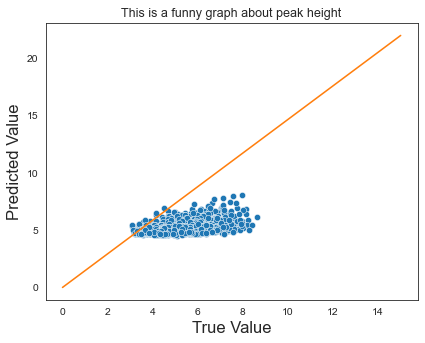

In [136]:
# X_test['Intercept'] = np.ones(X_test.shape[0])
# print(X_test.shape)
pred_y = results.predict(X)
sns.scatterplot(x=response['signal_value'], y=pred_y)
plt.plot([0, 15], [0, 22], color="tab:orange")
plt.xlabel("True Value", fontsize=16)
plt.ylabel("Predicted Value", fontsize=16)
plt.title("This is a funny graph about peak height")

In [137]:
print(len(response))
print(len(response[response['signal_value'] >= 5]))
print(len(response[response['signal_value'] < 5]))

2902
1512
1390
